In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from tqdm.notebook import tqdm


import gymnasium as gym
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper



import goexplore

In [3]:

env = gym.make('MiniGrid-Empty-16x16-v0', render_mode='rgb_array')
# env = RGBImgPartialObsWrapper(env) # Get pixel observations
# env = ImgObsWrapper(env) # Get rid of the 'mission' field
# env = FullyObsWrapper(env)
obs, _ = env.reset() # This now produces an RGB tensor only

In [7]:
env.env.env

In [45]:
obs.keys()

dict_keys(['image', 'direction', 'mission'])

0
get to the green goal square


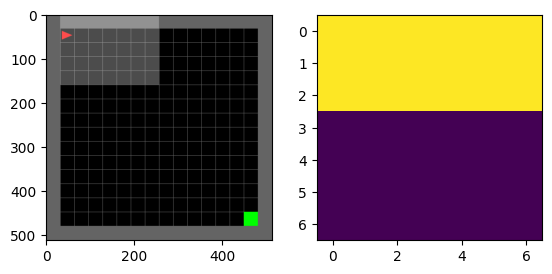

In [46]:
print(obs['direction'])
print(obs['mission'])
plt.subplot(121); plt.imshow(env.render())
plt.subplot(122); plt.imshow(obs['image'][..., 0])
plt.show()

In [ ]:
# def get_state(obs):
    # return 

In [89]:
env.env.env.env.agent_pos = (3, 4)

In [90]:
env.agent_dir = 2

In [91]:
env.agent_pos

(3, 4)

In [145]:
class State():
    def __init__(self, env, obs):
        self.img = obs['image'][..., 0]
        self.agent_pos = env.agent_pos
        self.agent_dir = env.agent_dir
        
def get_state(env, obs):
    return obs['image'][..., 0], env.agent_pos, env.agent_dir

def goto_state(env, state):
    image, pos, d = state
    env.env.env.env.agent_pos = pos
    env.env.env.env.agent_dir = d

env.env.env.env
env = gym.make('MiniGrid-Empty-8x8-v0', render_mode='rgb_array')
env = FullyObsWrapper(env)
obs, _ = env.reset()
s = get_state(env, obs)
archive = [s]
for i in tqdm(range(1000)):
    obs, _ = env.reset()
    state = archive[np.random.choice(len(archive))]
    goto_state(env, state)
    for i in range(3):
        obs, reward, done, info, _ = env.step(np.random.choice(3))
    state = get_state(env, obs)
    archive.append(state)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [439]:
def plot_current_latent_distribution(ge, c=None):
    latents = torch.stack([node.latent for node in ge.archive.nodes])
    latents, counts = torch.unique(latents, dim=0, return_counts=True)
    pos, d = latents[:, :2], latents[:, 2]
    dirs = 0.2*torch.tensor([[1, 0], [0, 1], [-1, 0], [0, -1]])
    x = pos+dirs[d]
    plt.xlim(0, 16); plt.ylim(0, 16)
    if c is None:
        c = counts
    plt.scatter(*x.numpy().T, c=c, s=10.)
    plt.colorbar()
    
def get_base_env(env):
    return get_base_env(env.env) if hasattr(env, 'env') else env

class MyMiniGrid(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        
    def step(self, action):
        obs, reward, done, _, info = self.env.step(action)
        state_sim = self.get_current_state_sim()
        (x, y), d = state_sim
        obs = torch.tensor([x, y, d])
        return state_sim, obs, reward, done, info
    
    def reset(self):
        obs, info = self.env.reset()
        state_sim = self.get_current_state_sim()
        (x, y), d = state_sim
        obs = torch.tensor([x, y, d])
        return state_sim, obs, 0, False, info
    
    def get_current_state_sim(self):
        return (self.env.agent_pos, self.env.agent_dir)
    
    def goto_state_sim(self, state):
        self.reset()
        p, d = state
        get_base_env(env).agent_pos = p
        get_base_env(env).agent_dir = d
    
env = gym.make('MiniGrid-Empty-16x16-v0', render_mode='rgb_array')
# env = FullyObsWrapper(env)
env = MyMiniGrid(env)
state_sim, obs, _, _, _ = env.reset()
    

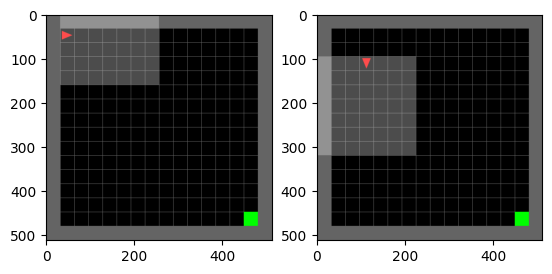

In [440]:
plt.subplot(121); plt.imshow(env.render())
env.goto_state_sim(((3, 3), 1))
plt.subplot(122); plt.imshow(env.render())
plt.show()
env.reset();

In [441]:
import sklearn.mixture

In [442]:
gm = sklearn.mixture.GaussianMixture(1, )
gm = gm.fit(np.zeros((3, 2))).fit(np.zeros((3, 2))).fit(np.zeros((3, 2)))

In [443]:
# every k iterations of BFS:

# sample a random batch of nodes from the tree
# compute their latents based on the current state2latent mapping
# compute how novel each latent state is
# compute productivities for node in the batch

# Run SGD with minibatches on the transitions from the trajectories weighted by the productivity of traj


In [447]:
env = gym.make('MiniGrid-Empty-16x16-v0', render_mode='rgb_array')
env = MyMiniGrid(env)
env.reset()
ge = goexplore.GoExplore(env, goexplore.RandomNodeSelector, MiniGridStateObs2Latent, RandomExplorer, n_exploration_steps=3)
# ge = goexplore.GoExplore(env, goexplore.GaussiainNodeSelector, MiniGridStateObs2Latent, RandomExplorer, n_exploration_steps=3)

  0%|          | 0/1000 [00:00<?, ?it/s]

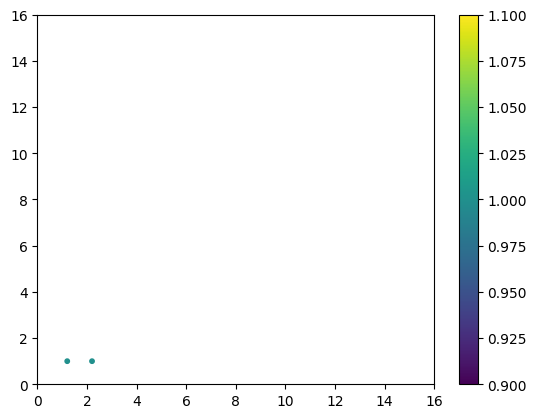

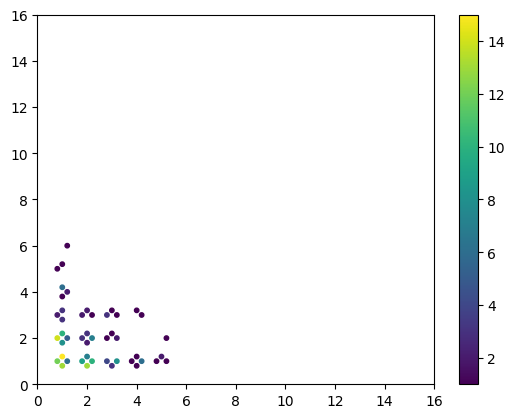

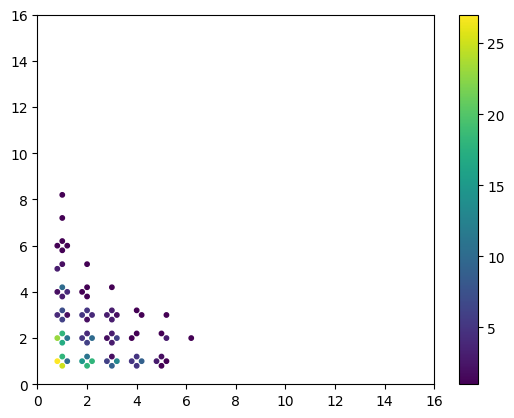

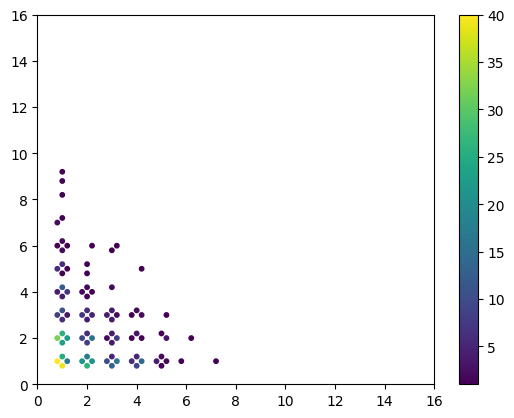

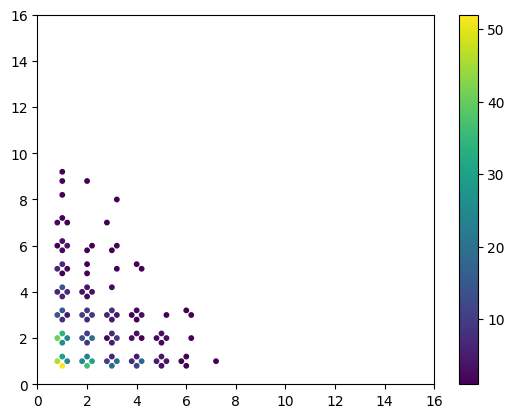

In [448]:
for i in tqdm(range(1000)):
    ge.run_iteration()
    
    if i%200==0:
        plot_current_latent_distribution(ge)
        plt.show()
        
        

    # if i%100==0:
        # learn the exploration stuff

In [547]:
productivities = compute_productivities(ge)
nodes = ge.archive.nodes[1:]
productivities = [productivities[node] for node in nodes]
trajs = [torch.stack([trans[1][:2] for trans in node.traj]) for node in nodes]

In [502]:
obs = np.array([1,1,3])
obs = torch.from_numpy(np.stack([obs]*32))
PolicyExplorer(ge).get_action(None, obs, None)

(tensor([0, 2, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 0, 1, 1, 2, 0, 0,
         0, 2, 0, 0, 1, 1, 2, 1]),
 tensor([-0.9285, -1.1766, -0.9285, -1.2156, -0.9285, -1.1766, -1.2156, -1.1766,
         -1.1766, -1.2156, -1.1766, -1.1766, -1.1766, -1.2156, -1.2156, -1.1766,
         -1.1766, -1.2156, -0.9285, -1.2156, -1.2156, -1.1766, -0.9285, -0.9285,
         -0.9285, -1.1766, -0.9285, -0.9285, -1.2156, -1.2156, -1.1766, -1.2156],
        grad_fn=<SqueezeBackward1>))

In [503]:
# batch of trajectories: n_traj, len_traj
# productivites/rewards for each one: n_traj



In [504]:
prods

array([0.19924817, 0.19622447, 0.17685962, ..., 0.05551921, 0.08095341,
       0.07439372])

tensor(0) tensor(9)


  0%|          | 0/10 [00:00<?, ?it/s]

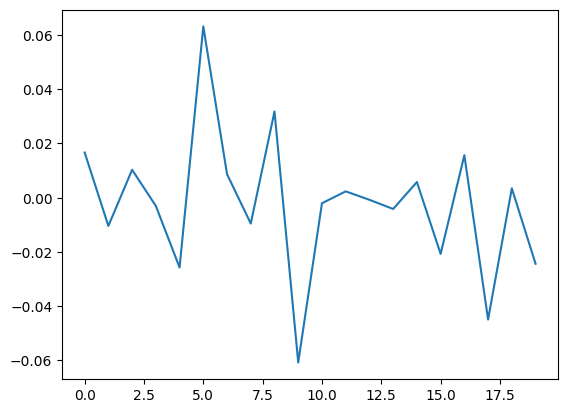

In [519]:
def temp(ge):
    nodes = ge.archive.nodes[1:] # ignore root because it has not trajectory
    n_trajs, len_traj = len(nodes), ge.n_exploration_steps
    
    # from each transition in the trajectories, only get the obs, action
    trajs = [[(trans[1], trans[2]) for trans in node.traj] for node in nodes]
    obss = torch.stack([torch.stack([trans[0] for trans in traj]) for traj in trajs])
    actions = torch.tensor([[trans[1] for trans in traj] for traj in trajs])
    # this is a list (of trajectories) of list (of transitions) of tuples (obs, action)
    
    
    prods = compute_productivities(ge)
    prods = torch.tensor([prods[node] for node in nodes])
    
    prods = prods[:, None].expand(-1, len_traj)
    
    # print(obss.shape, actions.shape, prods.shape)
    obss, actions, prods = obss.reshape(-1, obss.shape[-1]), actions.flatten(), prods.flatten()
    # print(obss.shape, actions.shape, prods.shape)
    
    # TODO normalize obs
    
    prods_norm = (prods - prods.mean())/(prods.std()+1e-6)
    
    explorer = PolicyExplorer(ge)
    
    opt = torch.optim.Adam(explorer.parameters(), lr=1e-3)
    
    bs = 2000
    losses = []
    for i_epoch in tqdm(range(10)):
        for i_batch, idxs in enumerate(torch.randperm(n_trajs*len_traj).split(bs)):
            obs, action, reward = obss[idxs], actions[idxs], prods_norm[idxs]

            a, log_prob = explorer.get_action(None, obs, None, action=action)
            assert a is action

            loss = (-reward*log_prob).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
            # print(loss.item())
    
    plt.plot(losses)
    plt.show()
        
    
    
temp(ge)

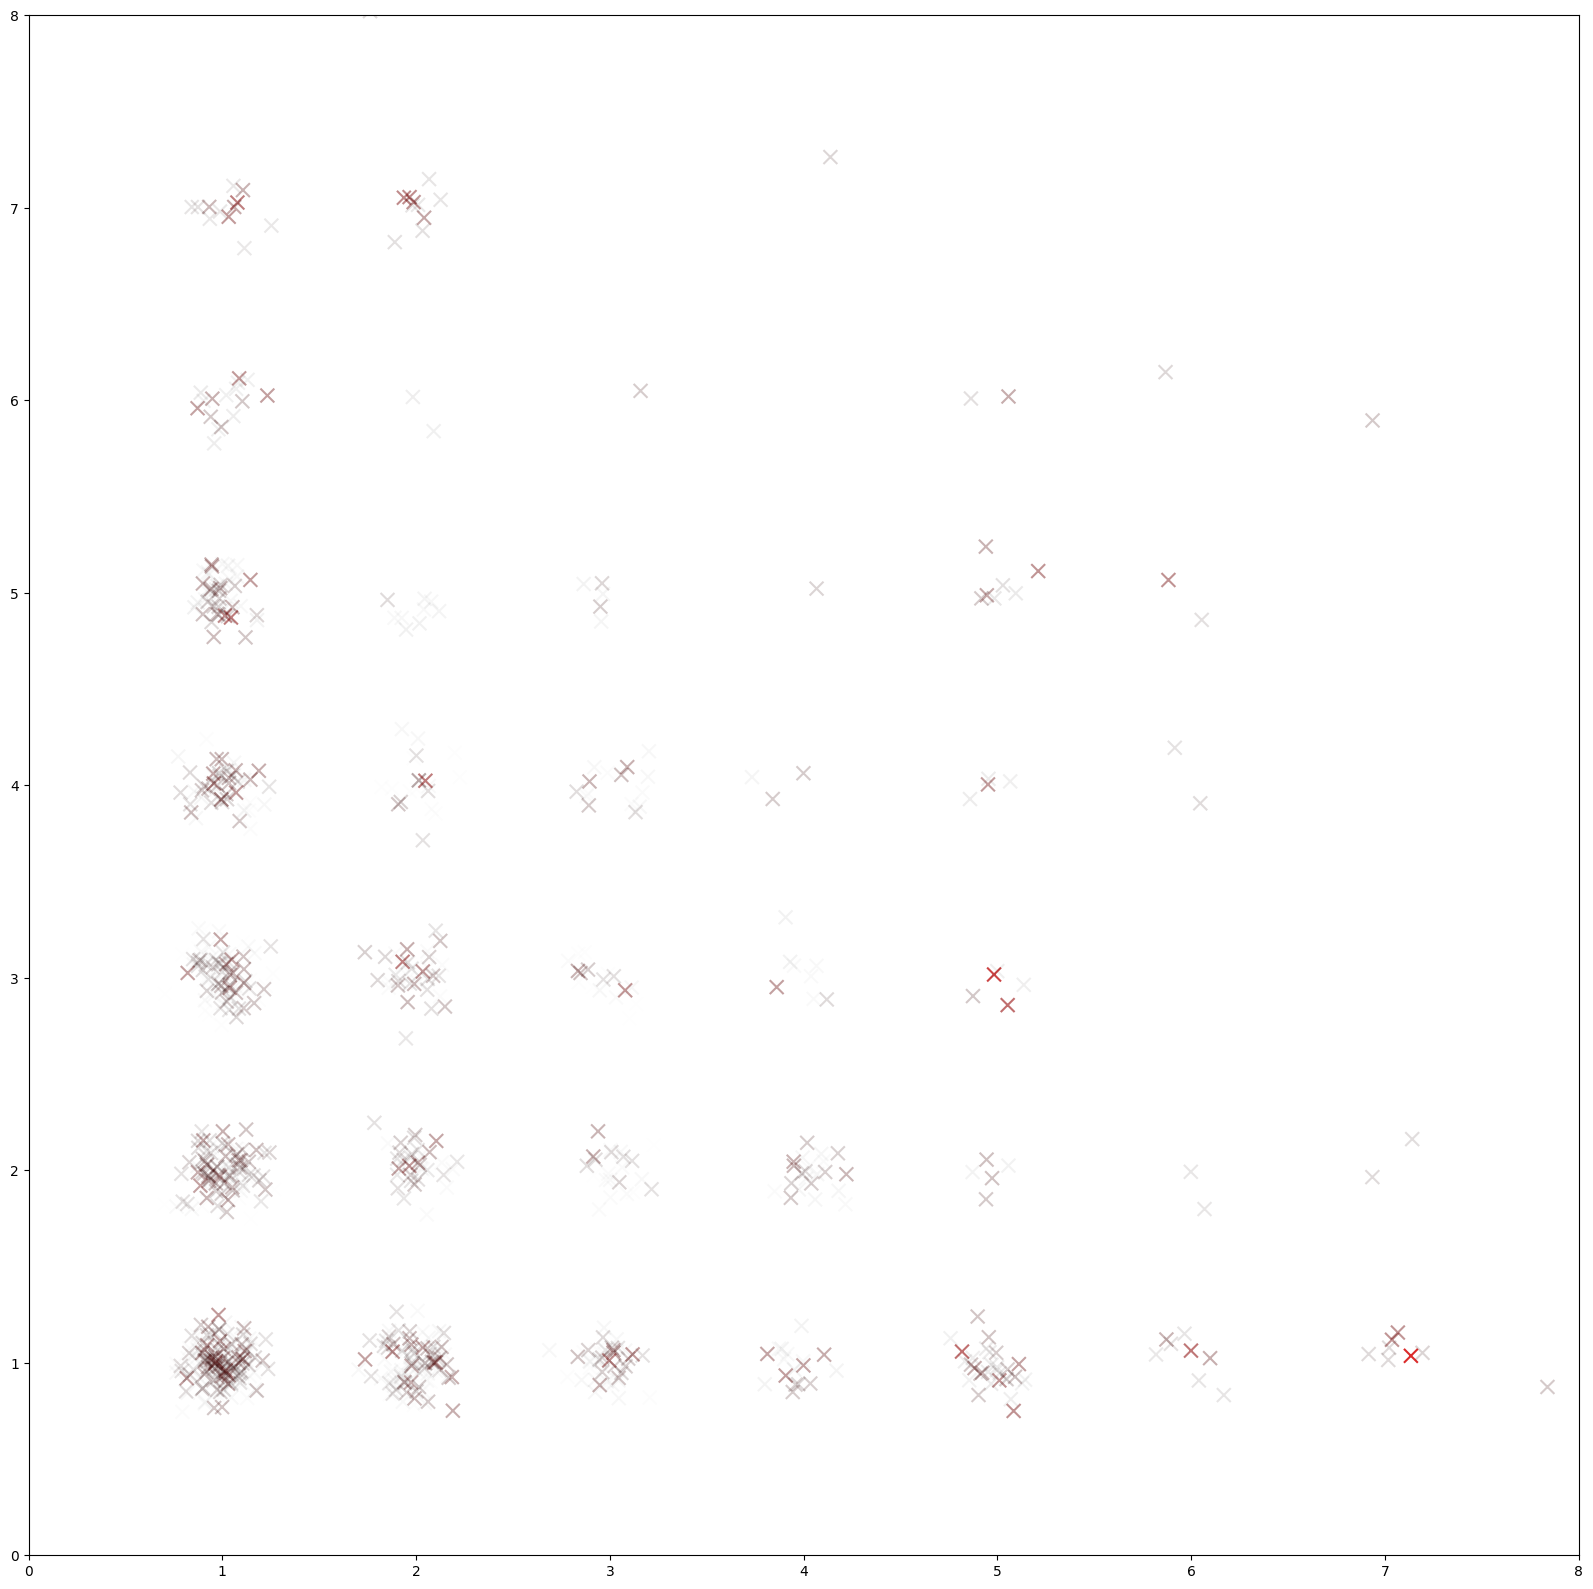

In [332]:
plt.figure(figsize=(20,20))
latents = np.array([node.latent for node in ge.archive.nodes])
x = latents[:, :2]
x = x + 0.1*np.random.randn(*x.shape)

c = (a-a.min())/(a.max()-a.min())
c = np.stack([c, np.zeros_like(c), np.zeros_like(c), c], axis=-1)
# plt.scatter(*x.T, c=a, s=50., marker='x')
plt.scatter(*x.T, c=c, s=100., marker='x')
# plt.colorbar()
plt.xlim(0, 8); plt.ylim(0, 8)
plt.show()


In [65]:
dirs = 0.2*np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
pos = np.array([node.state_sim[0] for node in ge.archive.nodes])
d = np.array([node.state_sim[1] for node in ge.archive.nodes])
visits = np.array([node.n_visits for node in ge.archive.nodes])
x = pos+dirs[d]
plt.xlim(0, 16); plt.ylim(0, 16)
plt.scatter(*x.T, c=visits, s=10.)
plt.colorbar(); plt.show()

AttributeError: 'Node' object has no attribute 'n_visits'

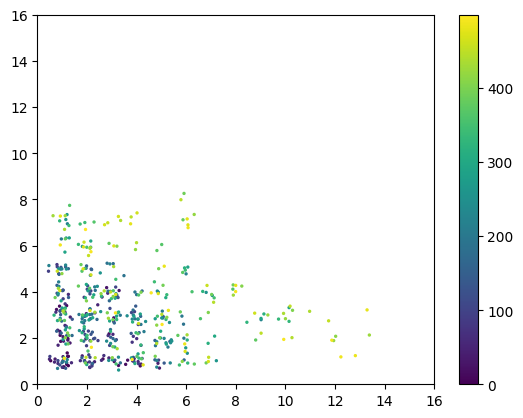

In [11]:
selected = np.array(ge.selected)
x = selected+np.random.randn(*selected.shape)*.2
plt.scatter(*x.T, c=np.arange(len(selected)), s=2)
plt.xlim(0, 16); plt.ylim(0, 16)
plt.colorbar(); plt.show()

In [12]:
len(ge.archive.nodes)

183

In [14]:
pos.shape

(183, 2)

In [16]:
import sklearn, sklearn.mixture
sklearn.mixture.GaussianMixture

sklearn.mixture._gaussian_mixture.GaussianMixture

(0.0, 16.0)

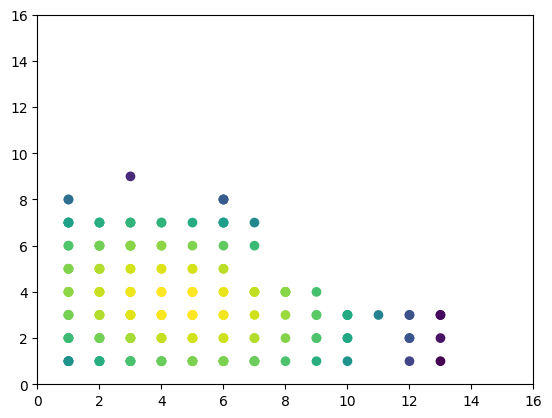

In [23]:
gm = sklearn.mixture.GaussianMixture(n_components=1, random_state=0).fit(pos)
gm.weights_, gm.means_, gm.covariances_
plt.scatter(*pos.T, c=gm.score_samples(pos))
plt.xlim(0, 16); plt.ylim(0, 16)

In [165]:
from treelib import Node, Tree

tree = Tree()

tree.create_node("Harry", "harry")  # No parent means its the root node
tree.create_node("Jane",  "jane"   , parent="harry")
tree.create_node("Bill",  "bill"   , parent="harry")
tree.create_node("Diane", "diane"  , parent="jane")
tree.create_node("Mary",  "mary"   , parent="diane")
tree.create_node("Mark",  "mark"   , parent="jane")

tree.show()

Harry
├── Bill
└── Jane
    ├── Diane
    │   └── Mary
    └── Mark



In [41]:
def get_str(node):
    return f'{node.state_sim[0][0]:2d}{node.state_sim[0][1]:2d}{node.state_sim[1]:2d} - {node.depth}'


get_str(ge.archive.nodes[0])

' 1 1 0 - 0'

In [42]:
import graphviz
g = graphviz.Digraph('G', filename='graph.gv')

for node in ge.archive.nodes:
    for child in node.children:
        g.edge(get_str(node), get_str(child))
# g.edge('World', 'tf')
# g.edge('tf', 'Hello')
g.view()

'graph.gv.pdf'

Unescaped left brace in regex is deprecated, passed through in regex; marked by <-- HERE in m/%{ <-- HERE (.*?)}/ at /usr/bin/run-mailcap line 528.
Error: no "view" rule for type "application/pdf" passed its test case
       (for more information, add "--debug=1" on the command line)


application/pdf D)ownload, or C)ancel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [197]:
for node in ge.archive.nodes:
    if node.node_parent is None:
        print(node.node_parent)
    for child in node.children:
        assert child.node_parent is node

None


In [149]:
# assert all entries in archive are unique
x = np.concatenate([pos, d[:, None]], axis=-1)
assert len(ge.archive.nodes) == len(np.unique(x, axis=0))
print(len(ge.archive.nodes))

380


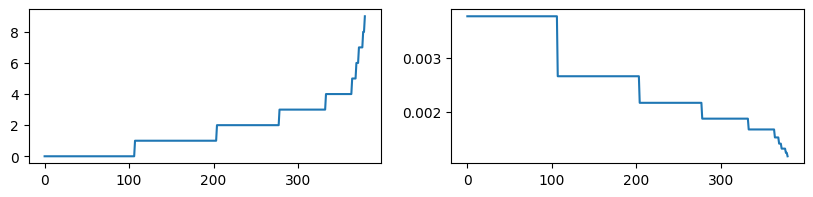

In [148]:
plt.figure(figsize=(10, 2))
plt.subplot(121); plt.plot(np.sort(visits))
p = 1/np.sqrt(np.sort(visits)+1)
p = p/p.sum()
plt.subplot(122); plt.plot(p)

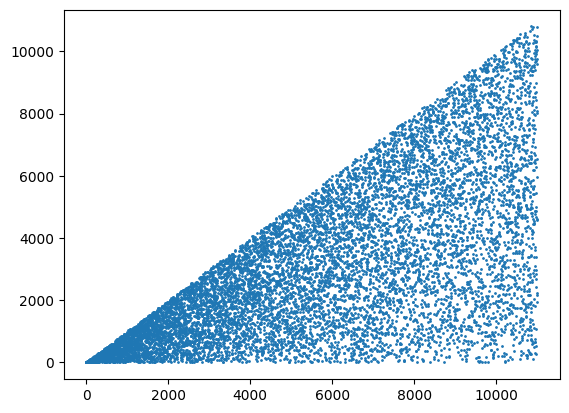

In [101]:
plt.scatter(np.arange(len(ge.selected)), ge.selected, s=1)

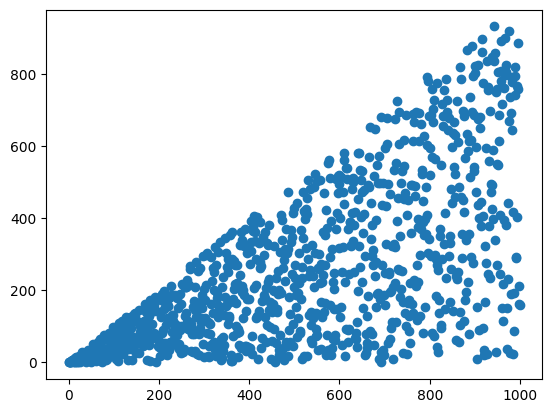

In [95]:
plt.scatter(np.arange(len(ge.selected)), ge.selected)

# testing PPO for novelty

In [13]:
import grid

In [39]:
env = grid.MyMiniGrid()
env.reset()

(tensor([-100, -100], dtype=torch.int32), tensor([-2., -2.]), 0, False, {})

In [130]:
x = torch.linspace(-2, 2, 50)
x, y = torch.meshgrid(x, x, indexing='ij')
grid = torch.stack([x,y], dim=-1).reshape(-1, 2)

In [131]:
np.random.seed(0)
archive = []
for i in tqdm(range(500)):
    env.reset()
    for j in range(100):
        state, obs, _, _, _ = env.step(np.random.choice(4))
    archive.append(obs)
    
archive = torch.stack(archive).unique(dim=0)

  0%|          | 0/500 [00:00<?, ?it/s]

In [132]:
import sklearn.mixture
gm = sklearn.mixture.GaussianMixture(n_components=1)
gm = gm.fit(archive.numpy())

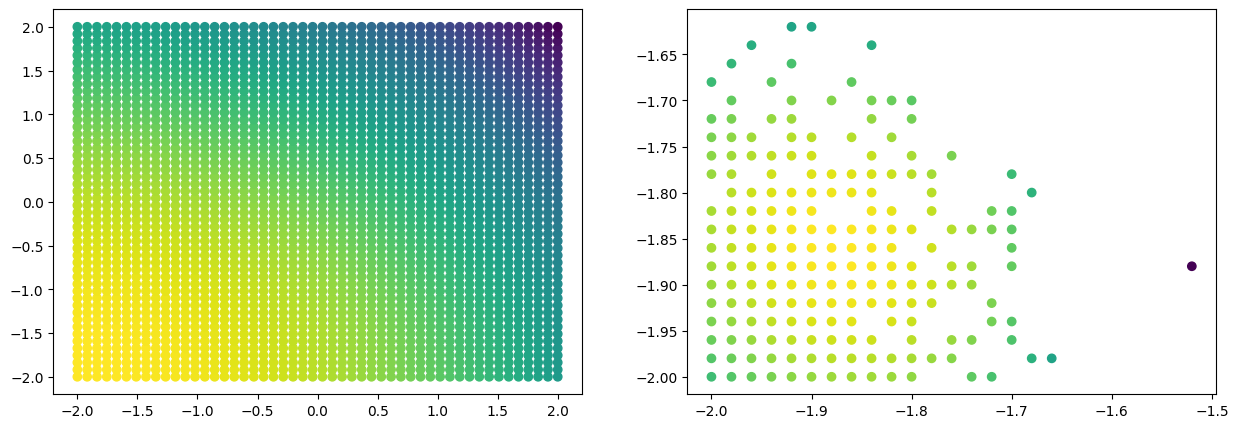

In [133]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
c = gm.score_samples(grid.numpy())
plt.scatter(*grid.numpy().T, c=c)
plt.subplot(122)
c = gm.score_samples(archive.numpy())
plt.scatter(*archive.numpy().T, c=c)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

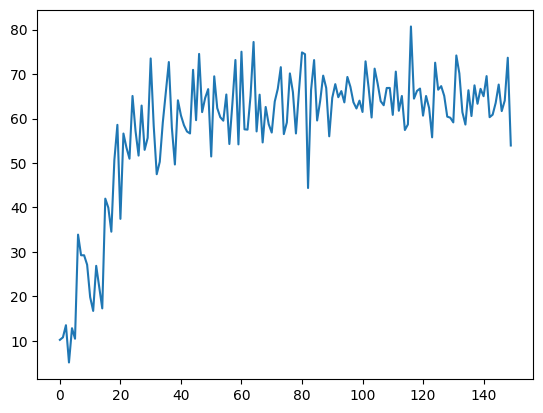

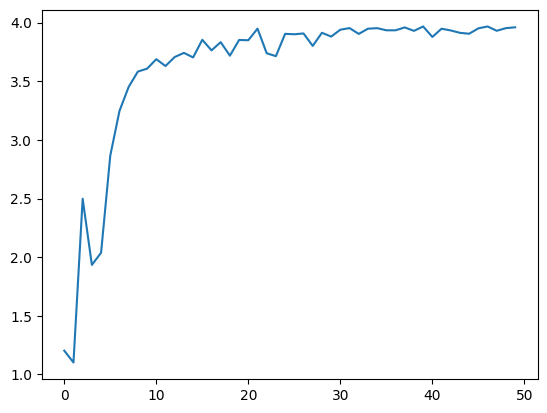

In [217]:
def flatten_then_batch(*args, batch_size=32):
    n_total = np.prod(args[0].shape[:2])
    for a in args:
        assert np.prod(args[0].shape[:2])==n_total
    idxs = torch.randperm(n_total).split(batch_size)
    for idx in idxs:
        yield [a.reshape((n_total,)+a.shape[2:])[idx] for a in args]
        
def compute_gae(rewards, values, gamma=0.99, gae_lambda=0.95):
    """
    Generalized Advantage Estimation
    rewards, values should have shape (n_trajs, len_traj)
    """
    t = torch.arange(rewards.shape[1]).expand(rewards.shape[0], -1)

    values_now, values_next = values[..., :-1], values[..., 1:]
    rewards_now, rewards_next = rewards[..., :-1], rewards[..., 1:]
    t_now, t_next = t[..., :-1], t[..., 1:]

    # Compute TD residual
    # shape: (n_trajs, len_traj-1)
    deltas_now = rewards_now + gamma * values_next - values_now
    def reverse_cumsum(x, dim=0):
        return x + x.sum(dim=dim, keepdims=True) - torch.cumsum(x, dim=dim)
    advantages = ((gamma*gae_lambda)**t_now) * deltas_now
    advantages = reverse_cumsum(advantages, dim=-1)
    returns = advantages + values_now
    return advantages, returns

def collect_data(state_start, agent, n_trajs, len_traj):
    obss = torch.zeros(n_trajs, len_traj, 2, dtype=torch.float32)
    actions = torch.zeros(n_trajs, len_traj, dtype=torch.int32)
    log_probs = torch.zeros(n_trajs, len_traj, dtype=torch.float32)
    values = torch.zeros(n_trajs, len_traj, dtype=torch.float32)
    rewards = torch.zeros(n_trajs, len_traj, dtype=torch.float32)
    
    for i_traj in range(n_trajs):
        state, obs, reward, done, info = env.reset(state=state_start)
        for i_trans in range(len_traj):
            with torch.no_grad():
                action, log_prob, entropy, value = agent.get_action_and_value(obs, action=None)
            state, obs, reward, done, info = env.step(action.item())
            
            obss[i_traj, i_trans] = obs
            actions[i_traj, i_trans] = action
            log_probs[i_traj, i_trans] = log_prob
            values[i_traj, i_trans] = value
            rewards[i_traj, i_trans] = reward
    return obss, actions, log_probs, values, rewards
            
def run_test(n_steps=1):
    agent = Agent()
    opt = torch.optim.Adam(agent.parameters(), lr=1e-2)
    
    clip_coef = 0.2
    clip_vloss = True
    ent_coef = 0.01
    vf_coef = 0.5
    max_grad_norm = 0.5
    
    o, r = [], []
    
    losses = []
    pbar = tqdm(range(n_steps))
    for i_step in pbar:
        state = torch.tensor([-85, -85], dtype=torch.int32)
        # state = torch.tensor([-90, -90], dtype=torch.int32)
        
        obss, actions, log_probs, values, rewards = collect_data(state, agent, 10, 10)
        o.append(obss)
        a = obss.reshape(-1, *obss.shape[2:]).numpy()
        rewards = torch.from_numpy(-gm.score_samples(a).reshape(*rewards.shape))
        r.append(rewards)
        advs, returns = compute_gae(rewards, values)
        
        
        everything = [obss[:, :-1], actions[:, :-1], log_probs[:, :-1], values[:, :-1], rewards[:, :-1], advs, returns]
        for batch in flatten_then_batch(*everything):
            obss_b, actions_b, log_probs_b, values_b, rewards_b, advs_b, returns_b = batch
            advs_b = (advs_b - advs_b.mean()) / (advs_b.std() + 1e-8)
            
            _, newlogprob_b, entropy_b, newvalues_b = agent.get_action_and_value(obss_b, actions_b)
            logratio = newlogprob_b - log_probs_b
            ratio = logratio.exp()
        
            pg_loss1 = -advs_b * ratio
            pg_loss2 = -advs_b * ratio.clamp(1 - clip_coef, 1 + clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            if clip_vloss:
                v_loss_unclipped = (newvalues_b - returns_b) ** 2
                v_clipped = values_b + (newvalues_b - values_b).clamp(-clip_coef, clip_coef)
                v_loss_clipped = (v_clipped - returns_b) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy_b.mean()
            loss = 1*pg_loss - ent_coef*entropy_loss + vf_coef*v_loss

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            opt.step()        
            
            pbar.set_postfix(loss=pg_loss.item())
            losses.append(loss.item())
    
    o = torch.stack(o)
    r = torch.stack(r)
    
    plt.plot(losses)
    plt.show()
    plt.plot(r.mean(dim=(1, 2)))
    plt.show()
    
    return o, r
    
     
torch.manual_seed(0)
np.random.seed(0)
o, r = run_test(50)

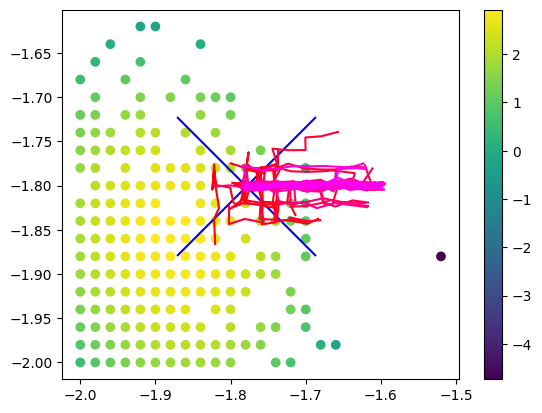

In [216]:
for i_step in range(50):
    for i_traj in range(1):
        a = o[i_step, i_traj]
        a = a+3e-3*torch.randn_like(a)
        plt.plot(*a.numpy().T, c=[1., 0., i_step/50, 1.])

# plt.scatter(-1.7, -1.7, c='b', marker='x')
c = gm.score_samples(archive.numpy())
plt.scatter(*archive.numpy().T, c=c)
plt.colorbar()

plt.scatter(*o[0, 0, 0], c='b', marker='x', s=10000)
plt.show()

In [85]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer
class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(2, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(2, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 4), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)